# Momentum

Momentum optimizer를 썼을 때 weight, velocity, cost의 변화를 시각적으로 살펴보자.

## 1. Prepare data

TV 광고에 따른 매출 변화 데이터

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('advertisement.csv')
data.head()

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
X = data.loc[:, 'TV'].values
y = data.loc[:, 'Sales'].values

In [4]:
print('X shape: {}'.format(X.shape))
print('y shape: {}'.format(y.shape))

X shape: (200,)
y shape: (200,)


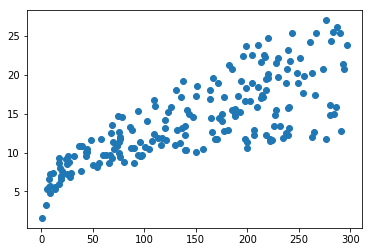

In [5]:
plt.scatter(X, y)
plt.show()
plt.close()

## 2. Loss shape : convex

- `advertisement.csv` 데이터에서 TV 광고 feature 하나만 사용
- 모델은 `f(x) = w*X + b` 형태로 사용

### 2.1 parameter가 독립이라면

- w와 b에 따른 loss의 변화를 그래프로 나타내면 아래와 같다. 둘 모두 convex 형태다.
- 물론 상관관계가 있기 때문에 아래 두 cost 그래프의 최적 w, b가 global optimum은 아니다.
- 단순히 각각이 convex 꼴인지만 시각적으로 보려고 그려봤다.

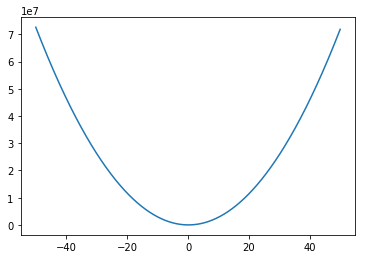

In [6]:
w_costs = []

for w in np.arange(-50, 50, 0.1):
    cost = np.sum(np.square(w * X - y)) / len(X)
    w_costs.append(cost)

plt.plot(np.arange(-50, 50, 0.1), w_costs)
plt.show()
plt.close()

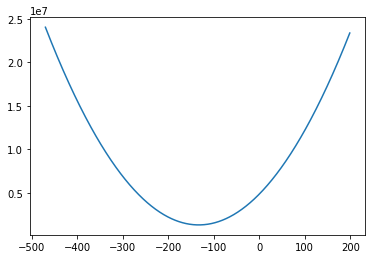

In [7]:
b_costs = []
start = -470
end = 200
for b in np.arange(start, end, 1):
    cost = np.sum(np.square(X + b - y))
    b_costs.append(cost)

plt.plot(np.arange(start, end, 1), b_costs)
plt.show()
plt.close()

### 2.2 Optimum value

- sklearn의 linear regression 모델을 활용해서 최적의 w, b를 구해보면 다음과 같다.
- 위 독립임을 가정하고 구했을 때의 최적값과 실제로 다르다 => 상관성 존재

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
X_input = X.reshape(-1, 1)
X_input.shape

(200, 1)

In [10]:
model = LinearRegression()
model.fit(X_input, y)

/Users/qbinson/.virtualenvs/fira/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
print('coef: {}'.format(model.coef_))
print('intercept: {}'.format(model.intercept_))

coef: [ 0.04753664]
intercept: 7.032593549127695


## 3. Gradient descent

### 3.1 Training

- 먼저 비교를 위해 Gradient descent를 가지고 몇 번의 iteration만에 수렴하는지 보자.
- learning rate는 `1e-05` 값으로 했고 `1e-04`로만 해도 수렴하지 못하고 발산해버린다.

In [12]:
ETA = 0.00001 # learning rate
PARAMS = [{'w':np.random.random(), 'b':0}] # random initialization
DERIVATIVES = []
COSTS = []

def gradient_descent(prev_w, prev_b, dw, db):
    w = prev_w - ETA*dw
    b = prev_b - ETA*db
    return w, b

def h(w, b):
    return w * X + b

In [13]:
def propagate(w, b):
    cost = np.sum(np.square(h(w, b) - y)) / len(X)
    
    dw = np.dot(h(w, b) - y, X) / len(X)
    db = np.sum(h(w, b) - y) / len(X)
    
    return cost, dw, db

def back_propagate(w, b, dw, db):
    new_w, new_b = gradient_descent(w, b, dw, db)
    return new_w, new_b

In [14]:
for i in range(500000):
    cost, dw, db = propagate(PARAMS[i]['w'], PARAMS[i]['b'])
    new_w, new_b = back_propagate(PARAMS[i]['w'], PARAMS[i]['b'], dw, db)
    
    PARAMS.append({'w': new_w, 'b': new_b})
    DERIVATIVES.append({'dw': dw, 'db': db})
    COSTS.append(cost)

In [15]:
PARAMS[-1]['w'], PARAMS[-1]['b']

(0.057603055444977271, 5.0503336184798089)

In [16]:
sklearn_w = model.coef_
sklearn_b = model.intercept_
sklearn_cost = np.sum(np.square(h(sklearn_w, sklearn_b) - y)) / len(X)
my_cost = np.sum(np.square(h(PARAMS[-1]['w'], PARAMS[-1]['b']) - y)) / len(X)

print("sklearn cost: {}".format(sklearn_cost))
print("my cost: {}".format(my_cost))

sklearn cost: 10.512652915656757
my cost: 11.507910043152208


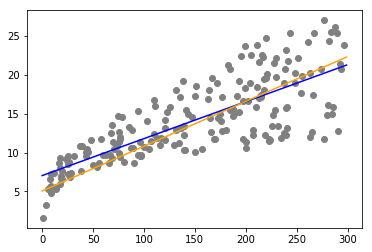

In [17]:
iteration = 300
plt.scatter(X, y, c='gray')
plt.plot(range(iteration), np.array(range(iteration)) * sklearn_w + sklearn_b, c='b')
plt.plot(range(iteration), np.array(range(iteration)) * PARAMS[-1]['w'] + PARAMS[-1]['b'], c='orange')
plt.show()
plt.close()

### 3.2 Visualize

- 50만번을 돌려도 위 sklearn을 통해 계산한 optimum까지 가진 못한다.
    + optimum은 `[0.0475, 7.0326]`, 50만번 돌면 `[0.0576, 5.0503]`
- 그래프 모양
    + cost: 초반에 급격하게 줄어들고, 그 후엔 정말 점진적으로 줄어든다.
    + params: weight는 초반에 급격하게 줄고, bias는 초반에 weight와 함께 줄어들다가 계속 상승한다.
    + derivatives: dw, db 모두 초반엔 급격하게 떨어지지만, db는 미미하게 상승한다.
- derivatives 해석
    + 그래프를 보면 dw, db 값이 크게 다르다. dw는 4000부터 떨어지지만, db는 20부터 떨어진다. 스케일이 크게 차이 남
    + 즉 cost graph에서 w축의 기울기는 매우 가파르고, b축은 매우 완만하다.
    + w는 빠르게 수렴하지만, b는 수렴하는데 굉장히 오래 걸린다.
- parameters 해석
    + 위 derivative의 크기 차이로 인해 weight와 bias의 그래프를 보면
    + weight는 10번도 안되서 빠르게 optimum 근처에 도달했지만(dw가 워낙 커서), bias는 50만번을 돌려야 겨우 근처까지 갔다.
    + weight의 값에 따라서 최적의 bias가 다르다는 것(그 반대도 역시)을 알 수 있다. 둘은 상관관계가 있다. 상관관계가 없었다면 bias의 변화가 저렇게 방향이 꺾이는 모양을 나타내지 않을 것
- X와 y의 데이터 스케일을 비슷하게 조정했다면 위와 같은 일이 덜 생겼을 것이다.

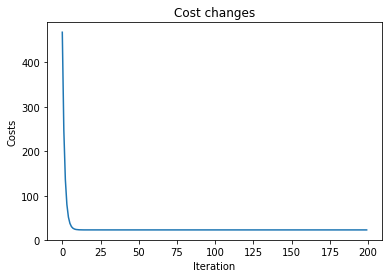

In [18]:
iteration = 200 # len(COSTS)
plt.plot(range(iteration), COSTS[:iteration])
plt.title('Cost changes')
plt.xlabel('Iteration')
plt.ylabel('Costs')
plt.show()
plt.close()

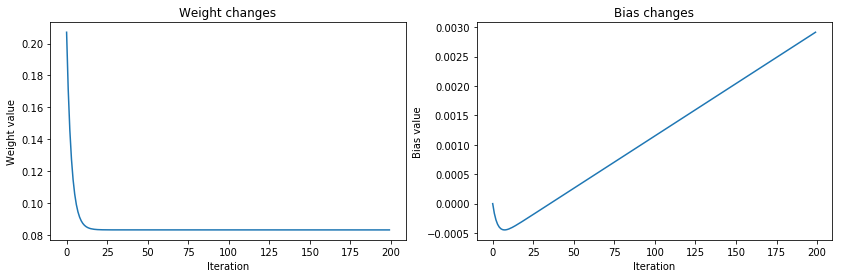

In [19]:
iteration = 200 # len(PARAMS)
plt.figure(1, figsize=(14,4))

plt.subplot(121)
plt.plot(range(iteration), list(map(lambda x: x['w'], PARAMS))[:iteration])
plt.title('Weight changes')
plt.xlabel('Iteration')
plt.ylabel('Weight value')

plt.subplot(122)
plt.plot(range(iteration), list(map(lambda x: x['b'], PARAMS))[:iteration])
plt.title('Bias changes')
plt.xlabel('Iteration')
plt.ylabel('Bias value')

plt.show()
plt.close()

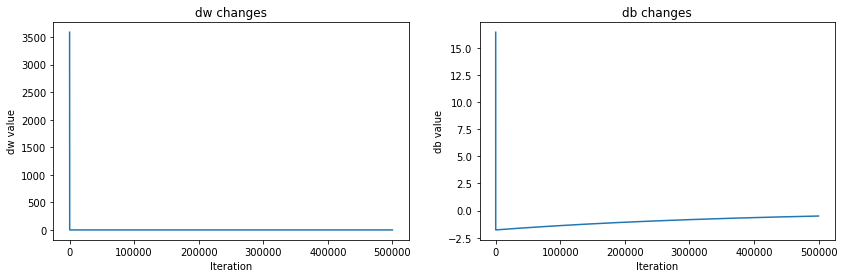

In [20]:
iteration = len(DERIVATIVES)
plt.figure(1, figsize=(14,4))

plt.subplot(121)
plt.plot(range(iteration), list(map(lambda x: x['dw'], DERIVATIVES))[:iteration])
plt.title('dw changes')
plt.xlabel('Iteration')
plt.ylabel('dw value')

plt.subplot(122)
plt.plot(range(iteration), list(map(lambda x: x['db'], DERIVATIVES))[:iteration])
plt.title('db changes')
plt.xlabel('Iteration')
plt.ylabel('db value')

plt.show()
plt.close()

## 4. Momentum optimizer

### 4.1 Training

$$
m_t = \beta m_{t-1} + \eta d \\
\theta_t = \theta_{t-1} - m_t
$$

- notation
    + $m_t$ : t 시점의 velocity
    + $\beta$ : friction(마찰)
    + $\eta$ : learning rate(eta)
    + $\theta_t$ : t 시점의 weight vector
- 코드 내용
    + propagate할 때 cost와 derivatives를 구한다
    + backpropagate할 때 momentum으로 weight 업데이트

In [21]:
# Global variables (X, y also)
BETA = 0.9 # friction
ETA = 0.00001 # learning rate

VELOCITIES = [{'v_w':0, 'v_b':0}] # initialized to 0
PARAMS = [{'w':np.random.random(), 'b':0}] # random initialization
DERIVATIVES = []
COSTS = []

# Momentum
def momentum(prev, dw, db):
    v_w = BETA*prev['v_w'] + ETA*dw
    v_b = BETA*prev['v_b'] + ETA*db
    VELOCITIES.append({'v_w': v_w, 'v_b': v_b})
    
    w = prev['w'] - v_w
    b = prev['b'] - v_b
    return w, b

In [22]:
def h(w, b):
    return w * X + b

def propagate(w, b):
    cost = np.sum(np.square(h(w, b) - y)) / len(X)
    
    dw = np.dot(h(w, b) - y, X) / len(X)
    db = np.sum(h(w, b) - y) / len(X)
    
    return cost, dw, db

def back_propagate(prev, dw, db):
    w, b = momentum(prev, dw, db)
    return w, b

In [23]:
for i in range(500000):
    # Forward propagate
    cost, dw, db = propagate(PARAMS[i]['w'], PARAMS[i]['b'])
    
    # Backword propagate
    prev = {'w': PARAMS[i]['w'], 'b': PARAMS[i]['b'],
            'v_w': VELOCITIES[i]['v_w'], 'v_b': VELOCITIES[i]['v_b']}
    new_w, new_b = back_propagate(prev, dw, db)

    COSTS.append(cost)
    DERIVATIVES.append({'dw': dw, 'db': db})
    PARAMS.append({'w': new_w, 'b': new_b})

확실히 Gradient descent보다 빠르다. Momentum으로 20만번만 iteration해도 거의 optimum에 근접한 수치가 나온다. 이전 GD 때는 50만을 해도 optimum 근처까지 도달하지 못했다.

In [24]:
PARAMS[-300000]['w'], PARAMS[-300000]['b']

(0.0477618603401289, 6.9882436592298109)

In [25]:
sklearn_w = model.coef_
sklearn_b = model.intercept_
sklearn_cost = np.sum(np.square(h(sklearn_w, sklearn_b) - y)) / len(X)
my_cost = np.sum(np.square(h(PARAMS[-1]['w'], PARAMS[-1]['b']) - y)) / len(X)

print("sklearn cost: {}".format(sklearn_cost))
print("my cost: {}".format(my_cost))

sklearn cost: 10.512652915656757
my cost: 10.512652915781473


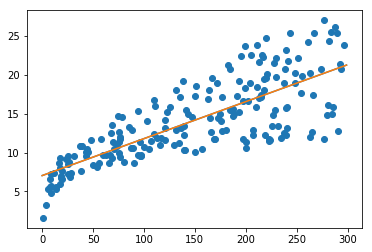

In [26]:
iteration = 300
plt.scatter(X, y)
plt.plot(range(iteration), np.array(range(iteration)) * sklearn_w + sklearn_b)
plt.plot(range(iteration), np.array(range(iteration)) * PARAMS[-1]['w'] + PARAMS[-1]['b'])
plt.show()
plt.close()

### 4.2 Visualize

- Cost가 들쭉날쭉한 것은 가장 큰 영향을 미치는 weight가 들쭉날쭉하기 때문이다.
- weight 변화 그래프를 보면 Momentum 특유의 optimum point를 기준으로 왔다갔다하는 모습(oscilating)을 볼 수 있다.
- bias는 weight 변화에 맞춰서 초반엔 함께 변하지만, weight가 최적화된 이후엔 쭉 상승한다.

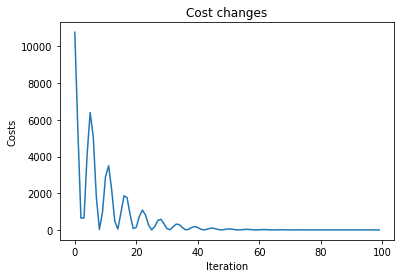

In [27]:
iteration = 100 # len(COSTS)
plt.plot(range(iteration), COSTS[:iteration])
plt.title('Cost changes')
plt.xlabel('Iteration')
plt.ylabel('Costs')
plt.show()
plt.close()

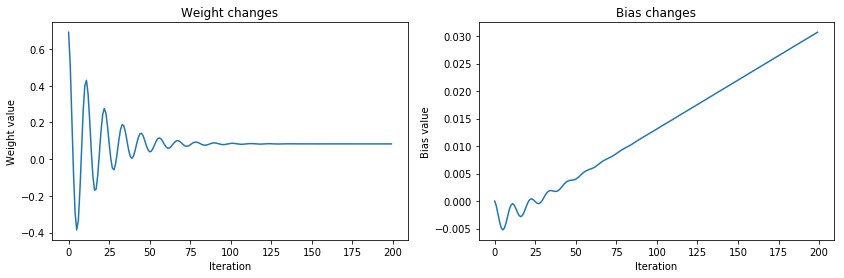

In [28]:
iteration = 200 # len(PARAMS)
plt.figure(1, figsize=(14,4))

plt.subplot(121)
plt.plot(range(iteration), list(map(lambda x: x['w'], PARAMS))[:iteration])
plt.title('Weight changes')
plt.xlabel('Iteration')
plt.ylabel('Weight value')

plt.subplot(122)
plt.plot(range(iteration), list(map(lambda x: x['b'], PARAMS))[:iteration])
plt.title('Bias changes')
plt.xlabel('Iteration')
plt.ylabel('Bias value')

plt.show()
plt.close()

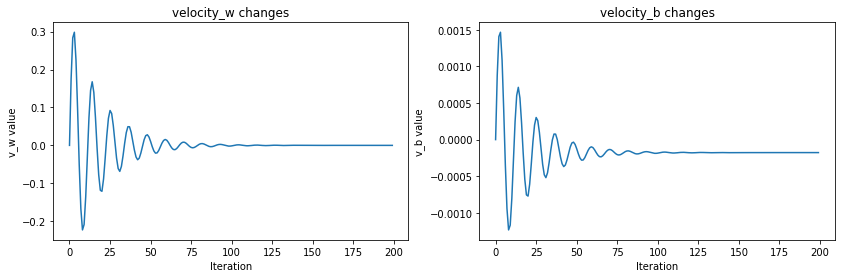

In [29]:
iteration = 200
plt.figure(1, figsize=(14,4))

plt.subplot(121)
plt.plot(range(iteration), list(map(lambda x: x['v_w'], VELOCITIES))[:iteration])
plt.title('velocity_w changes')
plt.xlabel('Iteration')
plt.ylabel('v_w value')

plt.subplot(122)
plt.plot(range(iteration), list(map(lambda x: x['v_b'], VELOCITIES))[:iteration])
plt.title('velocity_b changes')
plt.xlabel('Iteration')
plt.ylabel('v_b value')

plt.show()
plt.close()

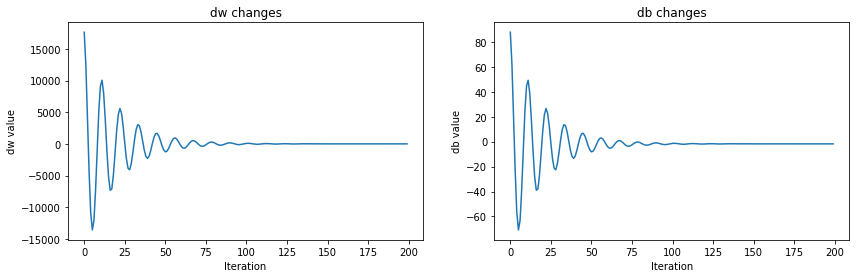

In [30]:
iteration = 200
plt.figure(1, figsize=(14,4))

plt.subplot(121)
plt.plot(range(iteration), list(map(lambda x: x['dw'], DERIVATIVES))[:iteration])
plt.title('dw changes')
plt.xlabel('Iteration')
plt.ylabel('dw value')

plt.subplot(122)
plt.plot(range(iteration), list(map(lambda x: x['db'], DERIVATIVES))[:iteration])
plt.title('db changes')
plt.xlabel('Iteration')
plt.ylabel('db value')

plt.show()
plt.close()

## 5. Simple example

### 5.1 Simple loss

- optimum theta는 0
- loss 그래프의 기울기는 언제나 1 또는 -1

In [31]:
def get_loss(x):
    return max(-x, x)

theta = np.arange(-10, 10, 0.01)
loss = []
for t in theta:
    loss.append(get_loss(t))

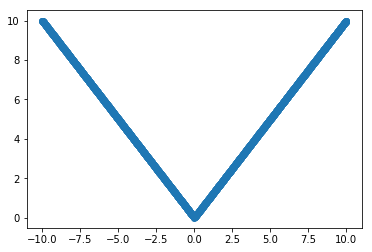

In [32]:
plt.scatter(theta, loss)
plt.show()
plt.close()

### 5.2 Theta and Velocity

- theta: 현재 기울기를 1로 고정해놨기 때문에 계속 줄어드는데, 점점 빠르게 줄어든다.
- velocity: 계속 증가하긴 하는데 결국 terminal velocity 값으로 수렴

In [33]:
beta = 0.9 # friction
eta = 0.01 # learning rate
d = 1 # Assume theta is initialized to any positive value
m = 0
t = 0
thetas = [10]
velocities = [0]

In [34]:
def get_next_veloicty(m):
    return beta * m + eta * d

def get_next_theta(theta, m):
    return theta - m

In [35]:
for i in range(50):
    next_v = get_next_veloicty(velocities[i])
    velocities.append(next_v)
    next_t = get_next_theta(thetas[i], next_v)
    thetas.append(next_t)

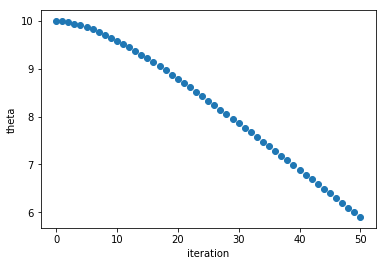

In [36]:
plt.scatter(range(51), thetas)
plt.xlabel('iteration')
plt.ylabel('theta')
plt.show()
plt.close()

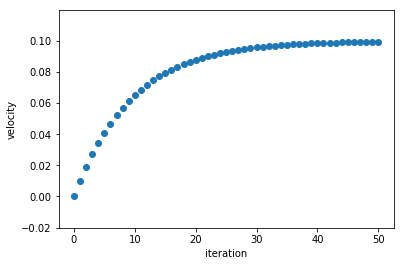

In [37]:
plt.scatter(range(51), velocities)
plt.xlabel('iteration')
plt.ylabel('velocity')
plt.show()
plt.close()